# Estudio Mono-Compartimental farmacocinético del Sunitinib + ketoconazol en ratones 🧪🐭

En este cuaderno se analiza el comportamiento farmacocinético de una formulación que contiene **sunitinib** combinado con **ketoconazol** en ratones.

Utilizamos un **modelo monocompartimental con absorción de primer orden** para describir la concentración del fármaco en distintos compartimentos: **Plasma**, **Cerebro**, **Riñón** e **Hígado**.

### Objetivos
- Estimar los parámetros: 
  - $k_e$: constante de eliminación
  - $t_{1/2}$: vida media
  - $k_a$: constante de absorción
  - Factor de concentración
- Calcular el error cuadrático total (SSR) y el criterio de información de Akaike (AIC)
- Comparar los valores reales y predichos mediante gráficas

In [158]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Cargar datos desde archivo
df = pd.read_csv('data.csv', index_col=0)
print(df)

         Cerebro    Plasma      Riñon      Higado
Tiempo                                           
0.00    0.000000  0.000000   0.000000    0.000000
0.08    2.375455  1.253699   7.725515   28.739378
0.25    2.428088  1.883693  17.777037   43.681615
0.50    2.473455  1.635242  22.042997   53.189255
1.00    3.671161  2.028957  35.874868   80.544272
2.00    4.597385  2.850109  66.188478  158.306083
4.00    6.108580  3.384569  64.424283  119.348789
6.00    4.235917  2.608140  53.622046   90.896761
8.00    2.888443  1.869260  39.509340   71.328054
12.00   2.103540  1.188970  19.110558   27.001372


## Función `analizar_compartimento`

Esta función estima los parámetros cinéticos a partir de los datos experimentales de un compartimento dado.

Se realiza el siguiente flujo:

1. Se encuentra el tiempo al que se alcanza la concentración máxima $C_{max}$ (es decir, $t_{max}$).
2. Se utiliza la fase terminal para ajustar una recta a \( \ln(C) \) y calcular:
   - $k_e = -\text{pendiente}$
   - $t_{1/2} = \frac{\ln(2)}{k_e}$
3. Se estima $k_a$ utilizando el **método de bisección** con la ecuación:

$$
\ln(x) = k_e \cdot (x - 1) \cdot t_{max}
$$

4. Se ajusta el modelo monocompartimental con absorción de primer orden:

$$
C(t) = F \cdot \left(e^{-k_e t} - e^{-k_a t} \right)
$$

Donde $F$ es un **factor de concentración** calculado a partir de $C_{max}$, $k_e$, y $k_a$.

5. Se calcula el **SSR** y el **AIC** para evaluar el ajuste.

In [159]:
def analizar_compartimento(df, compartimento):
    df_comp = df[[compartimento]].copy()
    df_comp.columns = ['Concentración']
    
    t_max = df_comp['Concentración'].idxmax()
    c_max = df_comp.loc[t_max, 'Concentración']
    
    df_terminal = df_comp.loc[t_max:].copy()
    tiempos_terminal = df_terminal.index.tolist()
    concentraciones_terminal = df_terminal['Concentración'].tolist()
    ln_concentraciones = np.log(concentraciones_terminal)

    pendiente, _ = np.polyfit(tiempos_terminal, ln_concentraciones, 1)
    k_e = -pendiente
    t_mitad = np.log(2) / k_e

    def ecuacion(x, k_e, t_max):
        return math.log(x) - k_e * (x - 1) * t_max

    def resolver_ka(k_e, t_max, x_inf=1.01, x_sup=20.0, tol=1e-7):
        f_inf = ecuacion(x_inf, k_e, t_max)
        f_sup = ecuacion(x_sup, k_e, t_max)
        if f_inf * f_sup > 0:
            raise ValueError("No hay cambio de signo en el intervalo.")
        while (x_sup - x_inf) > tol:
            x_med = (x_inf + x_sup) / 2
            f_med = ecuacion(x_med, k_e, t_max)
            if f_med == 0:
                return x_med * k_e
            if f_inf * f_med < 0:
                x_sup = x_med
                f_sup = f_med
            else:
                x_inf = x_med
                f_inf = f_med
        return (x_inf + x_sup) / 2 * k_e

    k_a = resolver_ka(k_e, t_max)
    factor = c_max / (np.exp(-k_e * t_max) - np.exp(-k_a * t_max))

    def concentracion_predicha(t, factor=factor, k_a=k_a, k_e=k_e):
        return factor * (np.exp(-k_e * t) - np.exp(-k_a * t))

    df_comp['Predicho'] = df_comp.index.to_series().apply(concentracion_predicha)
    df_comp['Error'] = df_comp['Concentración'] - df_comp['Predicho']
    df_comp['Error²'] = df_comp['Error']**2

    ssr = df_comp['Error²'].sum()
    p = 3
    n = len(df_comp) - 1
    aic = n * np.log(ssr / n) + 2 * p

    resultados = {
        'Comp': compartimento,
        'k_e (h^-1)': round(k_e, 4),
        't_½ (h)': round(t_mitad, 2),
        'k_a (h^-1)': round(k_a, 4),
        'Factor': round(factor, 4),
        'SSR': round(ssr, 4),
        'AIC': round(aic, 4),
        'Dataframe': df_comp
    }

    return resultados

## Aplicación del modelo a los compartimentos

Aplicamos la función `analizar_compartimento` a los siguientes compartimentos:

- Plasma
- Cerebro
- Riñón
- Hígado

Y mostramos los parámetros estimados para cada uno.

In [160]:
compartimentos = ['Plasma', 'Cerebro', 'Riñon', 'Higado']
resultados_finales = {}

for comp in compartimentos:
    resultados_finales[comp] = analizar_compartimento(df, comp)

## Visualización de los modelos

Comparamos la concentración real con la concentración predicha por el modelo monocompartimental con absorción para cada compartimento.

Se espera que el modelo prediga adecuadamente la fase de absorción y eliminación.

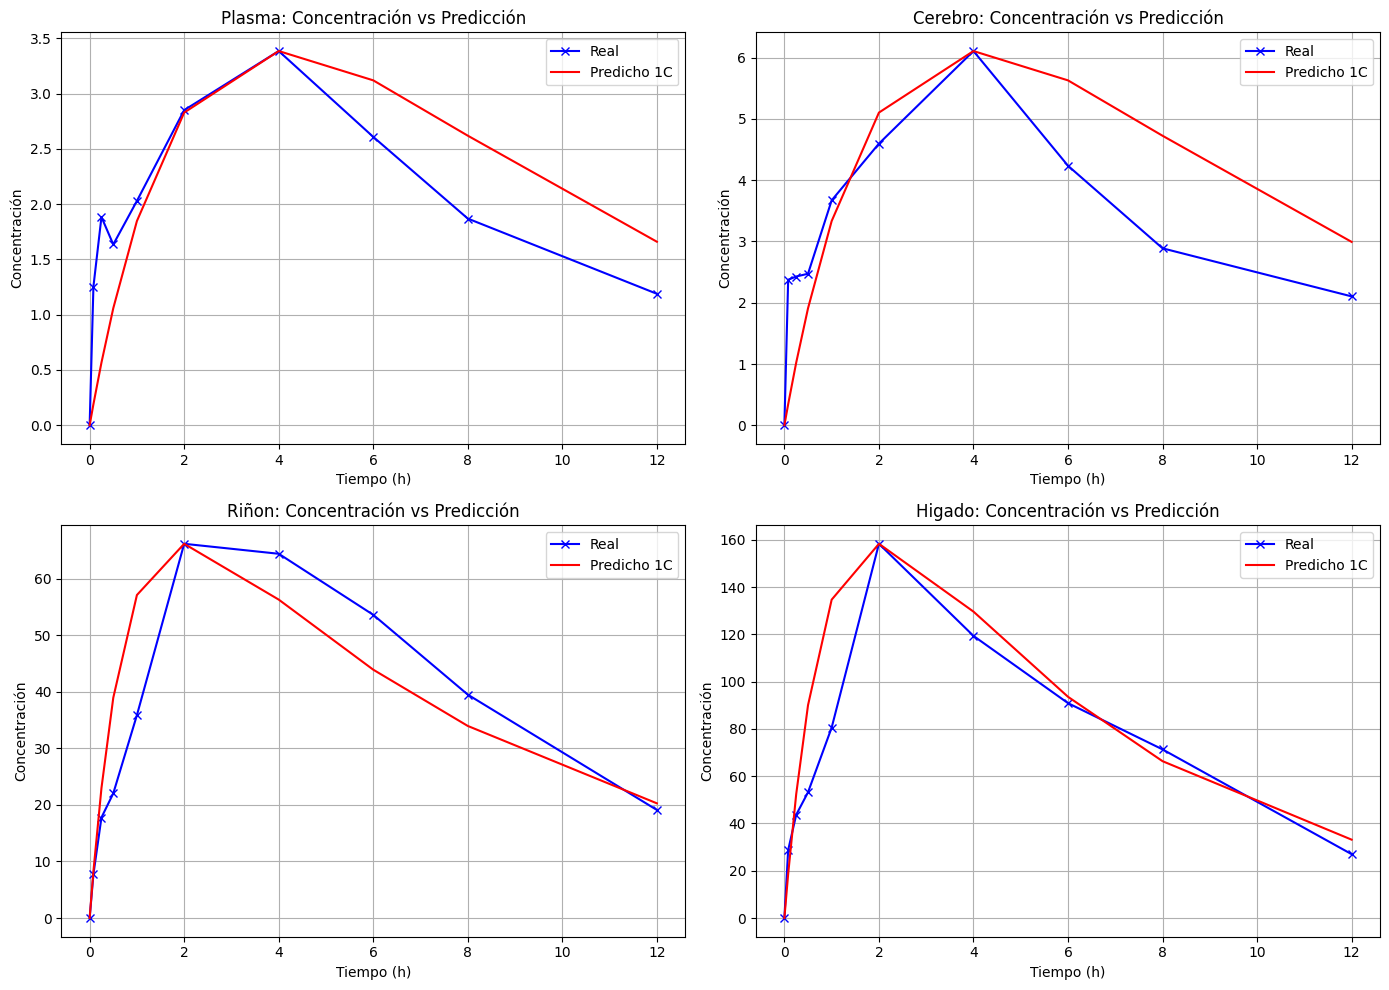

In [161]:
def graficar_todos_los_compartimentos(resultados):
    _, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    for i, (nombre, resultado) in enumerate(resultados.items()):
        df = resultado['Dataframe']
        axs[i].plot(df.index, df['Concentración'], label='Real', marker='x', color='blue')
        axs[i].plot(df.index, df['Predicho'], label='Predicho 1C', color='red')
        axs[i].set_title(f'{nombre}: Concentración vs Predicción')
        axs[i].set_xlabel('Tiempo (h)')
        axs[i].set_ylabel('Concentración')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

graficar_todos_los_compartimentos(resultados_finales)

# Estudio Bi-Compartimental farmacocinético del Sunitinib + ketoconazol en ratones 🧪🐭

Este análisis se basa en un estudio farmacocinético del fármaco **sunitinib combinado con ketotomasapredatidonazol** administrado a ratones. El objetivo es ajustar un modelo bicompartimental con absorción para describir la cinética del fármaco en distintos tejidos (plasma, hígado, riñón y cerebro), y calcular parámetros como:

- Tasa de absorción (`ka`)
- Tasas de eliminación de los compartimentos (`alfa`, `beta`)
- Concentración máxima (`Cmax`) y tiempo a la concentración máxima (`Tmax`)
- Área bajo la curva hasta infinito (`AUC_inf`)
- Semivida terminal (`t₁/₂`)
- Depuración aparente (`CL/F`)
- Volumen de distribución aparente (`Vd/F`)
- Tiempo medio de residencia (`MRT`)

In [162]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import simpson
import matplotlib.pyplot as plt

In [163]:
# Cargar datos desde archivo CSV
df = pd.read_csv('data.csv', index_col=0)
print(df)

# Datos de tiempo (horas)
tiempos = np.array(df.index.tolist()[1:])

# Concentraciones por tejido
concentraciones = {
    'Plasma':  np.array(df["Plasma"].tolist()[1:]),
    'Higado':  np.array(df["Higado"].tolist()[1:]),
    'Riñon':   np.array(df["Riñon"].tolist()[1:]),
    'Cerebro': np.array(df["Cerebro"].tolist()[1:]),
}

         Cerebro    Plasma      Riñon      Higado
Tiempo                                           
0.00    0.000000  0.000000   0.000000    0.000000
0.08    2.375455  1.253699   7.725515   28.739378
0.25    2.428088  1.883693  17.777037   43.681615
0.50    2.473455  1.635242  22.042997   53.189255
1.00    3.671161  2.028957  35.874868   80.544272
2.00    4.597385  2.850109  66.188478  158.306083
4.00    6.108580  3.384569  64.424283  119.348789
6.00    4.235917  2.608140  53.622046   90.896761
8.00    2.888443  1.869260  39.509340   71.328054
12.00   2.103540  1.188970  19.110558   27.001372


## Modelo bicompartimental con absorción

El modelo describe la concentración del fármaco `C(t)` en función del tiempo `t` mediante la siguiente ecuación:

$$
C(t) = A \left(e^{-\alpha t} - e^{-k_a t} \right) + B \left(e^{-\beta t} - e^{-k_a t} \right)
$$

Donde:
- \( k_a \): constante de absorción
- \( A \), \( B \): coeficientes de distribución
- \( \alpha \): tasa de distribución (fase rápida)
- \( \beta \): tasa de eliminación terminal (fase lenta)

In [164]:
def modelo_bicompartimental(t, ka, A, alfa, B, beta):
    return A * (np.exp(-alfa*t) - np.exp(-ka*t)) + B * (np.exp(-beta*t) - np.exp(-ka*t))

## Ajuste del modelo y cálculo de parámetros farmacocinéticos

Se ajusta el modelo bicompartimental a los datos experimentales usando mínimos cuadrados no lineales, y se calculan los siguientes parámetros:

- **Cmax**: concentración máxima predicha.
- **Tmax**: tiempo en el que ocurre Cmax.
- **AUC₀–∞**: área bajo la curva desde 0 hasta infinito, usando:

$$
AUC_{0-\infty} = AUC_{0-12h} + \frac{C_{\text{last}}}{\beta}
$$

- **t₁/₂** (semivida terminal):

$$
t_{1/2} = \frac{\ln 2}{\beta}
$$

- **CL/F** (depuración aparente):

$$
CL/F = \frac{D}{AUC_{0-\infty}} \quad \text{donde } D = 40 \, \mu g/kg
$$

- **Vd/F** (volumen de distribución aparente):

$$
Vd/F = \frac{CL/F}{\beta}
$$

- **MRT** (tiempo medio de residencia):

$$
MRT = \frac{Vd/F}{CL/F}
$$

- **SE_{AUC_{0-\infty}}** (error estándar del AUC extrapolado):

$$
SE_{AUC_{0-\infty}} = \frac{C_{\text{last}}}{\beta^2} \cdot SE_{\beta}
$$

- **SE_{CL/F}** (error estándar de la depuración aparente, por propagación):

$$
SE_{CL/F} = \frac{D}{AUC_{0-\infty}^2} \cdot SE_{AUC_{0-\infty}}
$$

In [165]:
def ajustar_tejido(nombre, concentracion_tejido):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, pcov = curve_fit(
        modelo_bicompartimental, 
        tiempos, concentracion_tejido, 
        p0=p0, bounds=(0, np.inf)
    )
    ka, A, alfa, B, beta = params

    t_fino = np.linspace(0, 12, 200)
    C_pred = modelo_bicompartimental(t_fino, *params)

    idx = np.argmax(C_pred)
    Cmax = C_pred[idx]
    Tmax = t_fino[idx]

    auc_0_12 = simpson(C_pred[t_fino <= 12], t_fino[t_fino <= 12])
    #auc_0_12 = simpson(modelo_bicompartimental(tiempos, *params), tiempos)
    Clast = C_pred[t_fino <= 12][-1]
    #Clast = modelo_bicompartimental(tiempos[-1], *params)
    auc_inf = auc_0_12 + Clast / beta

    t_mitad = np.log(2) / beta
    D = 40  # µg/kg
    CL_sobre_F = D / auc_inf
    Vd_sobre_F = CL_sobre_F / beta
    MRT = Vd_sobre_F / CL_sobre_F

    # Error estándar del AUC_inf (propagación de incertidumbre simple considerando beta)
    se_beta = np.sqrt(np.diag(pcov))[4]  # índice 4 es beta
    se_auc_inf = Clast / (beta ** 2) * se_beta  # derivada parcial de Clast/beta respecto a beta
    se_auc_inf = Clast / (beta ** 2) * se_beta

    # Error estándar del CL/F (por propagación)
    se_CL_sobre_F = D / (auc_inf ** 2) * se_auc_inf


    return {
        'Tejido': nombre,
        'ka': ka, 'alfa': alfa, 'beta': beta,
        'Cmax': Cmax, 'Tmax': Tmax,
        'AUC_inf': auc_inf, 'SE_AUC_inf': se_auc_inf,
        't1/2': t_mitad,
        'CL/F': CL_sobre_F, 'SE_CL/F': se_CL_sobre_F,
        'Vd/F': Vd_sobre_F, 'MRT': MRT,
        "A": A, "B": B
    }

In [166]:
resultados_inhibidor = [ajustar_tejido(t, c) for t, c in concentraciones.items()]
df_inhibidor = pd.DataFrame(resultados_inhibidor).set_index('Tejido').round(3)
print(df_inhibidor)

            ka   alfa   beta     Cmax   Tmax   AUC_inf  SE_AUC_inf   t1/2  \
Tejido                                                                      
Plasma   1.140  1.141  0.098    3.185  2.352    40.922      17.022  7.069   
Higado   0.426  0.399  0.111  141.103  2.653  1273.524   22700.578  6.218   
Riñon    0.782  0.794  0.181   68.430  3.196   641.877      85.610  3.838   
Cerebro  0.800  0.800  0.130    5.550  2.714    60.887      19.471  5.349   

          CL/F  SE_CL/F   Vd/F     MRT         A        B  
Tejido                                                     
Plasma   0.977    0.407  9.969  10.199     0.475    4.390  
Higado   0.031    0.560  0.282   8.971  4669.783   72.466  
Riñon    0.062    0.008  0.345   5.537  4349.814  169.873  
Cerebro  0.657    0.210  5.070   7.717     0.753    9.416  


## Comparación gráfica entre datos reales y predicción del modelo

En esta sección se grafican las concentraciones reales observadas y las curvas predichas por el modelo bicompartimental para cada tejido. Esto permite visualizar qué tan bien se ajusta el modelo a los datos experimentales.

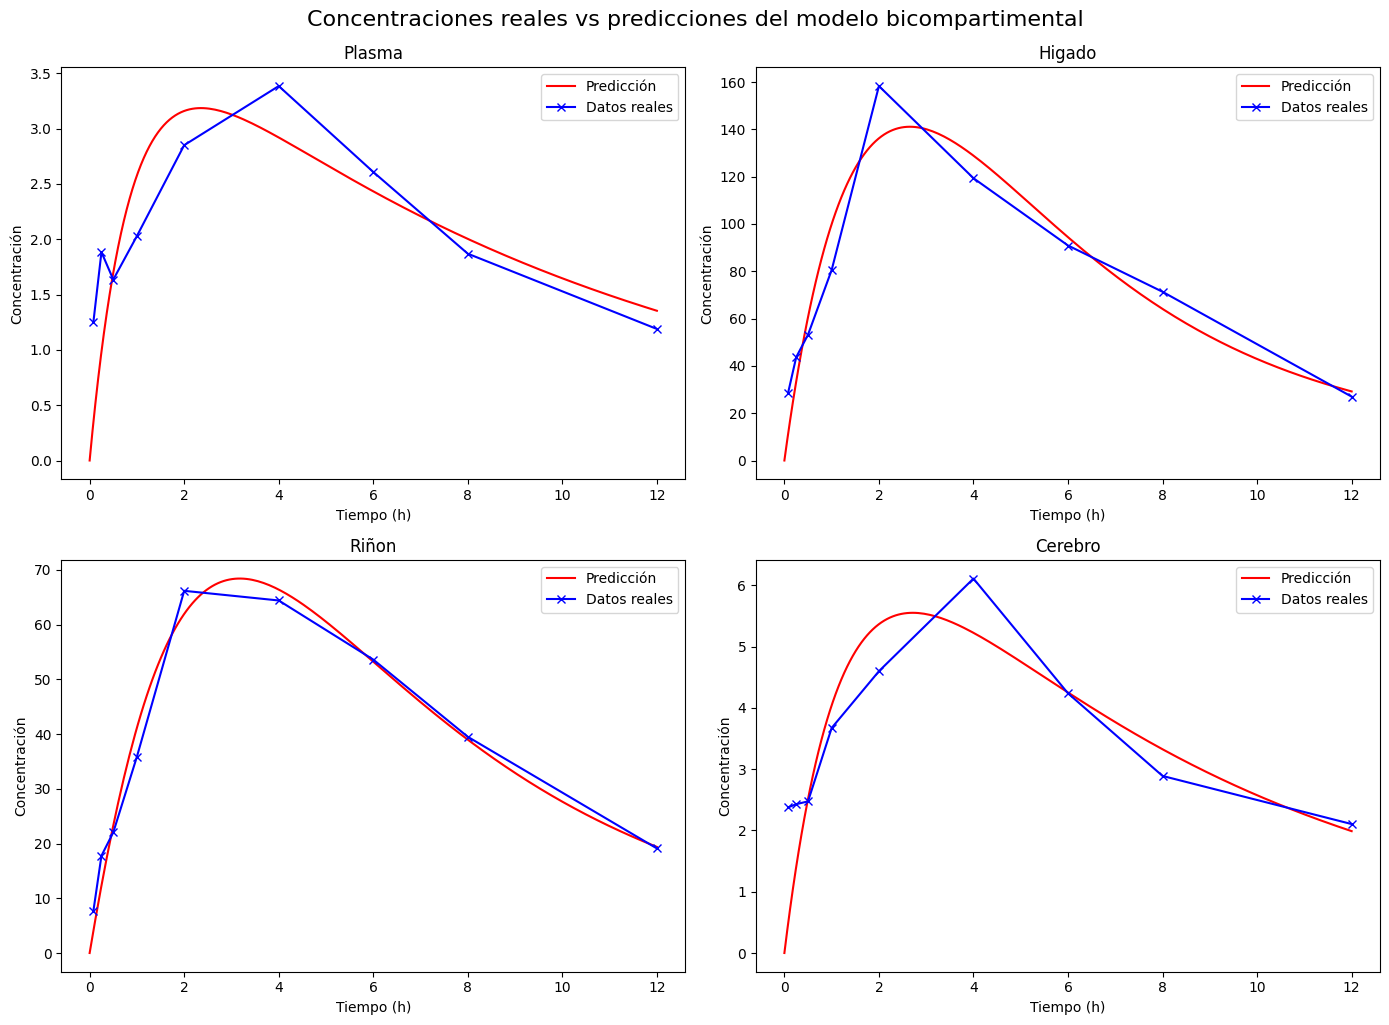

In [167]:
plt.figure(figsize=(14, 10))

for i, (nombre, concentracion_tejido) in enumerate(concentraciones.items()):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, _ = curve_fit(modelo_bicompartimental, tiempos, concentracion_tejido, p0=p0, bounds=(0, np.inf))

    t_fino = np.linspace(0, 12, 200)
    C_pred = modelo_bicompartimental(t_fino, *params)

    plt.subplot(2, 2, i + 1)
    plt.plot(t_fino, C_pred, label='Predicción', color='red')
    plt.plot(tiempos, concentracion_tejido, label='Datos reales', marker='x', color='blue')
    plt.xlabel('Tiempo (h)')
    plt.ylabel('Concentración')
    plt.title(nombre)
    plt.legend()

plt.tight_layout()
plt.suptitle('Concentraciones reales vs predicciones del modelo bicompartimental', fontsize=16, y=1.02)
plt.show()

# Conclusiones del estudio

En esta sección final de nuestro estudio, vamos a **evaluar cuantitativamente el ajuste de nuestros modelos** farmacocinéticos a los datos experimentales obtenidos de ratones tratados con sunitinib. Para ello, utilizaremos dos métricas muy importantes:

- **SSR (Suma de los Cuadrados del Residuo)**: mide el error total entre los valores predichos por un modelo y los valores observados. Cuanto menor sea el SSR, mejor es el ajuste del modelo.

- **AIC (Criterio de Información de Akaike)**: evalúa la calidad de un modelo teniendo en cuenta tanto el ajuste a los datos como la complejidad del modelo (número de parámetros). Un AIC más bajo indica un modelo más eficiente.

Vamos a comparar **cuatro funciones modelo** y determinar cuál se ajusta mejor a nuestros datos reales.

## Cálculo del SSR

El SSR (Suma de los Cuadrados del Residuo) se calcula usando la siguiente fórmula:

$$
SSR = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Donde:

- $y_i$ son los valores reales.
- $\hat{y}_i$ son los valores predichos por el modelo.


In [168]:
def calcular_ssr(observados, predichos):
    return np.sum((observados - predichos) ** 2)

## Cálculo del AIC

El AIC (Criterio de Información de Akaike) penaliza la complejidad del modelo. La fórmula que usaremos es:

$$
AIC = n \cdot \ln\left(\frac{SSR}{n}\right) + 2k
$$

Donde:

- $n$: número de observaciones.
- $SSR$: suma de los cuadrados de los residuos.
- $k$: número de parámetros del modelo.

Asumiremos lo siguiente para nuestros modelos:
- Modelo 1: 2 parámetros
- Modelo 2: 3 parámetros
- Modelo 3: 2 parámetros
- Modelo 4: 4 parámetros


In [169]:
def calcular_aic_bi(ssr, n, k=5):
    """
    Calcula el AIC para un modelo con 'k' parámetros.
    Por defecto, el modelo bicompartimental tiene 5 parámetros: A, B, alpha, beta, ka
    """
    return n * np.log(ssr / n) + 2 * k

## Conclusiones

In [170]:
resultados_df = []

for comp, res in resultados_finales.items():
    resultados_df.append({
        "Tejido": comp.upper(),
        "Modelo": "Monocompartimental",
        "SSR": res["SSR"],
        "AIC": res["AIC"]
    })

for i, (nombre, concentracion_tejido) in enumerate(concentraciones.items()):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, _ = curve_fit(modelo_bicompartimental, tiempos, concentracion_tejido, p0=p0, bounds=(0, np.inf))

    C_pred = modelo_bicompartimental(tiempos, *params)
    ssr = calcular_ssr(concentracion_tejido, C_pred)
    aic = calcular_aic_bi(ssr, len(concentracion_tejido))

    resultados_df.append({
        "Tejido": nombre.upper(),
        "Modelo": "Bicompartimental",
        "SSR": ssr,
        "AIC": aic
    })

df_resultados = pd.DataFrame(resultados_df)
df_resultados = df_resultados.sort_values(by=["Tejido", "Modelo"])
df_resultados.set_index("Modelo", inplace=True)
print(df_resultados)

                     Tejido          SSR        AIC
Modelo                                             
Bicompartimental    CEREBRO     6.324883   6.825402
Monocompartimental  CEREBRO    12.903700   9.242600
Bicompartimental     HIGADO  1485.013923  55.953594
Monocompartimental   HIGADO  4641.323000  62.209800
Bicompartimental     PLASMA     2.322398  -2.191619
Monocompartimental   PLASMA     4.276900  -0.695900
Bicompartimental      RIÑON    94.974923  31.207495
Monocompartimental    RIÑON   956.999700  47.999200


Al comparar los modelos farmacocinéticos mono y bicompartimental en diferentes tejidos (cerebro, hígado, plasma y riñón), se observa que el modelo bicompartimental proporciona un mejor ajuste general a los datos. Esto se evidencia tanto por los valores más bajos de **Suma de los Cuadrados de los Residuos (SSR)** como por los **criterios de información de Akaike (AIC)** más reducidos en todos los tejidos evaluados. En particular, las diferencias son más marcadas en tejidos como el hígado y el riñón, donde el modelo bicompartimental reduce significativamente el error de ajuste en comparación con el monocompartimental. Estos resultados sugieren que el comportamiento farmacocinético del compuesto estudiado se describe mejor con un enfoque bicompartimental, reflejando posiblemente una distribución más compleja en los tejidos analizados.

# Aplicar modelo Bi-Compartimental sobre los datos de Test

In [171]:
# Cargar datos desde archivo CSV
df = pd.read_csv('test.csv', index_col=0)
print(df)

# Datos de tiempo (horas)
tiempos = np.array(df.index.tolist()[1:])

# Concentraciones por tejido
concentraciones = {
    'Plasma':  np.array(df["Plasma"].tolist()[1:]),
    'Higado':  np.array(df["Higado"].tolist()[1:]),
    'Riñon':   np.array(df["Riñon"].tolist()[1:]),
    'Cerebro': np.array(df["Cerebro"].tolist()[1:]),
}

         Cerebro    Plasma     Higado       Riñon
Tiempo                                           
0.00    0.010000  0.010000   0.010000    0.010000
0.08    1.478175  0.761520   5.620105   27.757062
0.25    1.542916  1.140623  13.975576   49.453853
0.50    2.860693  2.716908  65.792679  107.025753
1.00    2.118253  1.732809  33.339625   78.384621
2.00    2.117737  1.967675  37.041934   68.008447
4.00    2.117785  1.238243  30.133649   36.716059
6.00    2.025212  1.056993  21.450501   27.188582
8.00    1.752101  0.964013  14.368102   15.055364
12.00   1.468479  0.714241   9.960894    5.880010


In [172]:
resultados_control = [ajustar_tejido(t, c) for t, c in concentraciones.items()]
df_control = pd.DataFrame(resultados_control).set_index('Tejido').round(3)
print(df_control)

            ka   alfa   beta    Cmax   Tmax  AUC_inf  SE_AUC_inf    t1/2  \
Tejido                                                                     
Plasma   2.245  2.202  0.087   2.225  0.724   22.019       8.047   7.932   
Higado   2.102  1.840  0.121  45.624  0.844  359.293     144.925   5.725   
Riñon    2.040  2.023  0.213  92.700  0.724  427.977      28.970   3.256   
Cerebro  7.039  1.957  0.036   2.381  0.603   65.727      45.382  19.386   

          CL/F  SE_CL/F    Vd/F     MRT          A       B  
Tejido                                                      
Plasma   1.817    0.664  20.788  11.443    133.456   1.898  
Higado   0.111    0.045   0.920   8.260    331.606  43.277  
Riñon    0.093    0.006   0.439   4.697  13162.078  89.006  
Cerebro  0.609    0.420  17.020  27.967      0.368   2.357  


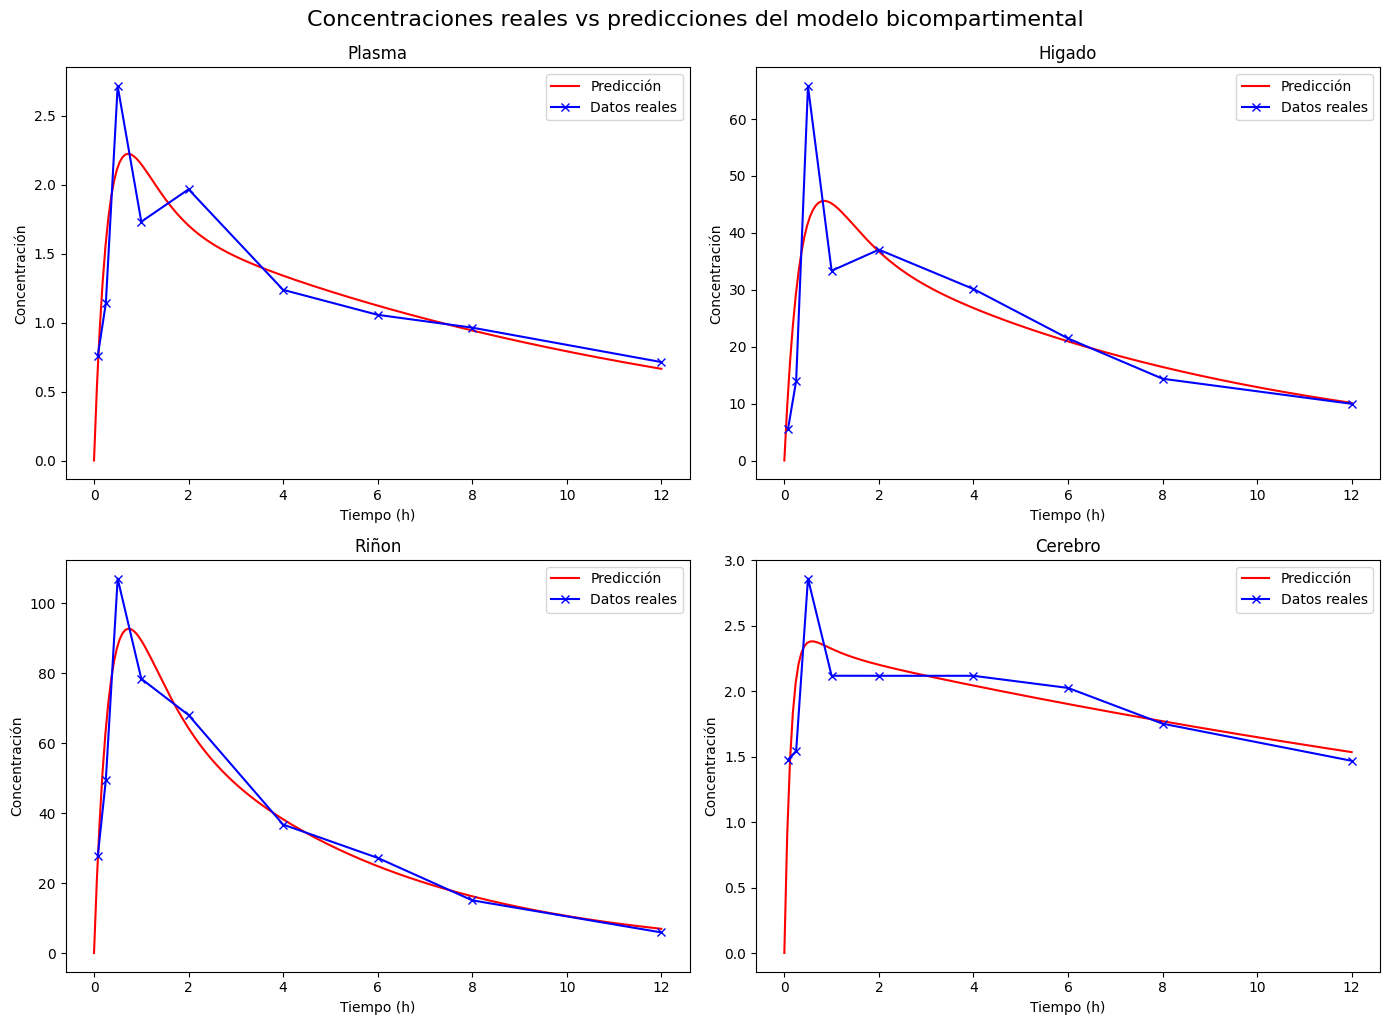

In [173]:
plt.figure(figsize=(14, 10))

for i, (nombre, concentracion_tejido) in enumerate(concentraciones.items()):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, _ = curve_fit(modelo_bicompartimental, tiempos, concentracion_tejido, p0=p0, bounds=(0, np.inf))

    t_fino = np.linspace(0, 12, 200)
    C_pred = modelo_bicompartimental(t_fino, *params)

    plt.subplot(2, 2, i + 1)
    plt.plot(t_fino, C_pred, label='Predicción', color='red')
    plt.plot(tiempos, concentracion_tejido, label='Datos reales', marker='x', color='blue')
    plt.xlabel('Tiempo (h)')
    plt.ylabel('Concentración')
    plt.title(nombre)
    plt.legend()

plt.tight_layout()
plt.suptitle('Concentraciones reales vs predicciones del modelo bicompartimental', fontsize=16, y=1.02)
plt.show()

# Análisis de diferencias de AUC usando el Test de Yuan

En este análisis comparamos los valores de **AUC_inf** entre un grupo **control** y un grupo **inhibidor** utilizando el **Test de Yuan**, considerando la varianza en **CL/F** (Clearance/F).

## Funciones utilizadas

### Calcular la varianza del AUC_inf

La fórmula para la varianza de AUC es:

$$
\text{Var}(AUC) = \frac{\text{dosis}^2 \times \text{Var}(CL/F)}{(CL/F)^4}
$$

donde:

- $\text{Var}(CL/F) = (SE_{CL/F})^2$



In [177]:
def calcular_varianza_auc(dosis, CL, SE_CL):
    var_CL = SE_CL ** 2
    var_AUC = (dosis ** 2 * var_CL) / (CL ** 4)
    return var_AUC, var_CL

### Test de Yuan para comparar AUC_inf

El estadístico de prueba \(Z\) se calcula como:

$$
Z = \frac{AUC_{\text{control}} - AUC_{\text{inhibidor}}}{\sqrt{\frac{\text{Var}(AUC_{\text{control}})}{n_{\text{control}}} + \frac{\text{Var}(AUC_{\text{inhibidor}})}{n_{\text{inhibidor}}}}}
$$

El valor p (p-value) se calcula como:

$$
p\text{-value} = 2 \times \text{P}(Z > |z|)
$$



In [ ]:
from scipy.stats import norm
def yuan_test(control_auc, control_var, inhibitor_auc, inhibitor_var, n_control, n_inhibitor):
    se_combined = np.sqrt((control_var / n_control) + (inhibitor_var / n_inhibitor))
    z_stat = (control_auc - inhibitor_auc) / se_combined
    p_value = 2 * norm.sf(np.abs(z_stat))
    return z_stat, p_value

In [187]:
dosis = 40  # Dosis administrada
n_control = 4  # Número de animales en el grupo control
n_inhibitor = 4  # Número de animales en el grupo inhibidor

resultados = {}

for tejido in df_control.index:
    # Valores para control
    auc_c = df_control.loc[tejido, 'AUC_inf']
    cl_c = df_control.loc[tejido, 'CL/F']
    se_cl_c = df_control.loc[tejido, 'SE_CL/F']
    var_auc_c, var_cl_c = calcular_varianza_auc(dosis, cl_c, se_cl_c)

    # Valores para inhibidor
    auc_i = df_inhibidor.loc[tejido, 'AUC_inf']
    cl_i = df_inhibidor.loc[tejido, 'CL/F']
    se_cl_i = df_inhibidor.loc[tejido, 'SE_CL/F']
    var_auc_i, var_cl_i = calcular_varianza_auc(dosis, cl_i, se_cl_i)

    # Guardar resultados
    resultados[tejido] = {
        'AUC_Control': auc_c,
        'Var_CL_Control': var_cl_c,
        'AUC_Inhibidor': auc_i,
        'Var_CL_Inhibidor': var_cl_i,
        
    }

resultados_df = pd.DataFrame(resultados).T

In [ ]:
# ------------------------------------------------------------
# 1) Renombramos las columnas de varianza (opcional, solo por claridad)
# ------------------------------------------------------------
df = resultados_df.rename(
    columns={
        "Var_CL_Control":   "Var_AUC_Control",
        "Var_CL_Inhibidor": "Var_AUC_Inhibidor",
    }
)

# ------------------------------------------------------------
# 2) Parámetros del experimento
# ------------------------------------------------------------
n_control = n_inhibitor = 4   # número de animales en cada grupo

# ------------------------------------------------------------
# 3) Aplicamos la función fila a fila
# ------------------------------------------------------------
(
    df[["Z", "p-value"]]  # columnas que vamos a crear
    # obtenemos dos columnas a la vez a partir de la tupla devuelta
) = df.apply(
    lambda row: yuan_test(
        row["AUC_Control"],
        row["Var_AUC_Control"],
        row["AUC_Inhibidor"],
        row["Var_AUC_Inhibidor"],
        n_control,
        n_inhibitor,
    ),
    axis=1,
    result_type="expand",   # para que devuelva dos columnas
)

# ------------------------------------------------------------
# 4) Columna de significancia
# ------------------------------------------------------------
df["Significativo"] = np.where(df["p-value"] < 0.05, "Sí", "No")

# ------------------------------------------------------------
# 5) Redondeo y selección de columnas de salida
# ------------------------------------------------------------
cols_redondear = [
    "AUC_Control",
    "Var_AUC_Control",
    "AUC_Inhibidor",
    "Var_AUC_Inhibidor",
    "Z",
    "p-value",
]
df[cols_redondear] = df[cols_redondear].round(6)

resultado = df[
    [
        "AUC_Control",
        "Var_AUC_Control",
        "AUC_Inhibidor",
        "Var_AUC_Inhibidor",
        "Z",
        "p-value",
        "Significativo",
    ]
]

print(resultado)


         AUC_Control  Var_AUC_Control  AUC_Inhibidor  Var_AUC_Inhibidor  \
Plasma        22.019         0.440896         40.922           0.165649   
Higado       359.293         0.002025       1273.524           0.313600   
Riñon        427.977         0.000036        641.877           0.000064   
Cerebro       65.727         0.176400         60.887           0.044100   

                    Z  p-value Significativo  
Plasma     -48.543291      0.0            Sí  
Higado   -3254.619643      0.0            Sí  
Riñon   -42780.000000      0.0            Sí  
Cerebro     20.614417      0.0            Sí  


## Interpretación

- Si el valor **p < 0.05**, se considera que hay una diferencia estadísticamente significativa en los valores de AUC_inf entre el grupo control y el grupo inhibidor para ese tejido.
- El **estadístico Z** indica cuántas desviaciones estándar separan los valores de AUC entre los grupos.

Se compararon los valores de AUC entre **Control** e **Inhibidor**. Todos los cambios fueron **estadísticamente significativos (p = 0.0)**, lo que implica un **efecto real del inhibidor** sobre la farmacocinética en cada tejido.

| Tejido   | Efecto del Inhibidor | Implicación |
|----------|-----------------------|-------------|
| **Plasma**   | ↑ AUC                  | Mayor exposición sistémica, el inhibidor podría reducir el aclaramiento. |
| **Hígado**   | ↑↑ AUC                | Acumulación hepática marcada, posible inhibición del metabolismo hepático. |
| **Riñón**    | ↑ AUC                  | Mayor retención renal, podría afectar la excreción. |
| **Cerebro**  | ↓ AUC                  | Menor penetración al SNC, el inhibidor podría estar bloqueando el paso a través de la barrera hematoencefálica. |